In [1]:
import numpy as np
import pylab
from qiskit import Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE 
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.operators import WeightedPauliOperator
import matplotlib.pyplot as plt

from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Qiskit Aer noise module imports
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error
from qiskit.providers.aer import noise

In [2]:
provider = IBMQ.load_account()

/opt/anaconda3/envs/QPT2/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Define a problem to be solved with VQE

In [3]:
pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
              {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "ZI"},
              {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "IZ"},
              {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
              {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}
              ]
}

qubit_op = WeightedPauliOperator.from_dict(pauli_dict)
num_qubits = qubit_op.num_qubits
print('Number of qubits: {}'.format(num_qubits))

Number of qubits: 2


# Solve it classically for comparison

In [4]:
ee = NumPyEigensolver(qubit_op.copy()) 
result = ee.run()
ref = result['eigenvalues'] 
print('Reference value: {}'.format(ref))

Reference value: [-1.85727503-3.77606111e-17j]


### Performance *with* noise

Now we will add noise. 

Note: simulation with noise takes significantly longer than without noise.

In [5]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u3', 'cx', 'reset', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


In [6]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=167, seed_transpiler=167,
                                   noise_model=noise_thermal)

counts1 = []
values1 = []
def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)
    

aqua_globals.random_seed = 167
optimizer = SPSA(maxiter=200) 
from qiskit.circuit.library import RealAmplitudes
var_form = RealAmplitudes(num_qubits)
vqe = VQE(qubit_op, var_form, optimizer, callback=store_intermediate_result1)
vqe_result1 = vqe.run(quantum_instance)
print('VQE on Aer qasm simulator (with noise): {}'.format(vqe_result1['eigenvalue'])) #'energy' deprecated
print('Delta from reference: {}'.format(vqe_result1['eigenvalue']-ref)) #'energy' deprecated

VQE on Aer qasm simulator (with noise): (-1.8193398600806043+0j)
Delta from reference: [0.03793517+3.77606111e-17j]


/opt/anaconda3/envs/QPT2/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


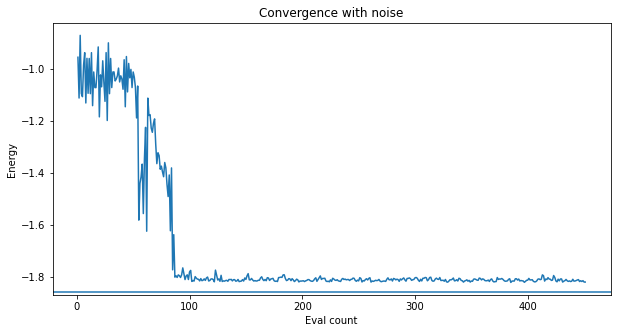

In [7]:
plt.figure(figsize=[10,5])
plt.plot(counts1, values1)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with noise');
plt.axhline(ref)

# Lower T1 values

In [8]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(5e3, 1e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(7e3, 1e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u3', 'cx', 'reset', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


In [9]:
device = provider.get_backend('ibmq_valencia')
coupling_map = device.configuration().coupling_map
#noise_model = noise.device.basic_device_noise_model(device.properties())
noise_model = NoiseModel.from_backend(device.properties()) # method above is deprecated
basis_gates = noise_model.basis_gates

print(noise_model)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=167, seed_transpiler=167,
                                   noise_model=noise_thermal)

counts = []
values = []
def store_intermediate_result1(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    

aqua_globals.random_seed = 167
#optimizer = SPSA(max_trials=200)
optimizer = SPSA(maxiter=200) #max_trials property is deprecated
#var_form = RY(num_qubits)
var_form = RealAmplitudes(num_qubits) #RY is deprecated
vqe = VQE(qubit_op, var_form, optimizer, callback=store_intermediate_result1)
vqe_result1 = vqe.run(quantum_instance)
print('VQE on Aer qasm simulator (with noise): {}'.format(vqe_result1['eigenvalue'])) #'energy' deprecated
print('Delta from reference: {}'.format(vqe_result1['eigenvalue']-ref)) #'energy' deprecated

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u3', 'cx', 'u2', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
VQE on Aer qasm simulator (with noise): (-1.5882408399504115+0j)
Delta from reference: [0.26903419+3.77606111e-17j]


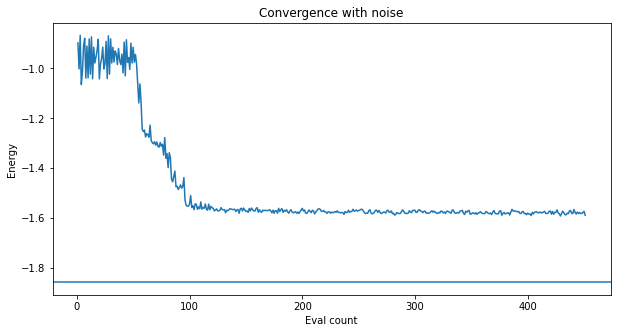

In [10]:
plt.figure(figsize=[10,5])
plt.plot(counts, values)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with noise');
plt.axhline(ref)

In [11]:
device = provider.get_backend('ibmq_valencia')
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
basis_gates = noise_model.basis_gates

print(noise_model)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=167, seed_transpiler=167,
                                   noise_model=noise_model)

counts1 = []
values1 = []
def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)
    

aqua_globals.random_seed = 167
optimizer = SPSA(maxiter=200) 
from qiskit.circuit.library import RealAmplitudes
var_form = RealAmplitudes(num_qubits)
vqe = VQE(qubit_op, var_form, optimizer, callback=store_intermediate_result1)
vqe_result1 = vqe.run(quantum_instance)
print('VQE on Aer qasm simulator (with noise): {}'.format(vqe_result1['eigenvalue'])) #'energy' deprecated
print('Delta from reference: {}'.format(vqe_result1['eigenvalue']-ref)) #'energy' deprecated

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'u3', 'cx', 'u2', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
VQE on Aer qasm simulator (with noise): (-1.7623537800696387+0j)
Delta from reference: [0.09492125+3.77606111e-17j]


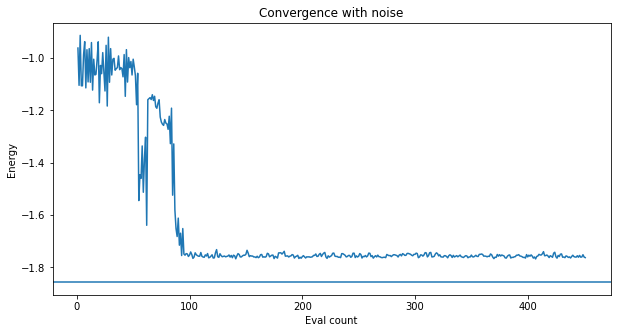

In [12]:
plt.figure(figsize=[10,5])
plt.plot(counts1, values1)
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Convergence with noise');
plt.axhline(ref)

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright